**3 задание (до 28.10 включительно)**
- Берем данные, которые использовали для первого задания;
- Применяем DTW (любой центройд), визуализируем результат;
- Применяем иерархический DTW. Визуализируем результат, пишем небольшой сравнительный анализ иерархической кластеризации базовой и DTW. Чем отличаются эти методы?
- Что такое DTW distance? Как оно рассчитывается&

-----

In [1]:
import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans, silhouette_score

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import yfinance as yf

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_3568\654444354.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [101]:
import scipy.cluster.hierarchy as hac

import dtaidistance
from dtaidistance import clustering, dtw

from sklearn.manifold import TSNE, MDS

# Load data

In [2]:
trending_list = ['PYPL', 'AI', 'ETH-USD', 'ZM', 'AMGN', 'LUNA1-USD', 'KO', 'PLUG', 'ZIM', 'ADBE', 'WBA', 'ABBV']
most_actives_list = ['AAPL', 'AMD', 'VALE', 'CCL', 'TSLA', 'NVDA', 'F', 'AMZN',  'T', 'CS', 'NIO', 'BBD', 'INTC', 'BAC', 'ITUB', 'DKNG', 'MSFT', 'AAL', 'PCG', 'ABEV',  'META', 'MPW', 'RIG', 'TWTR', 'VZ']
gainers_list = ['BDDDY', 'WXIBF', 'CANO', 'FBBPF', 'MSGS', 'FNMAL', 'STOSF', 'DXCM', 'WXXWY', 'FMCCS', 'ATCO']
losers_list = ['AMD', 'HKD', 'LAC', 'ACAD', 'LNTH', 'MRVL', 'LEVI', 'LAZR', 'APE', 'RBLX', 'SYNA', 'NTLA', 'CVS', 'SPT', 'CFLT', 'SCRYY', 'AFRM', 'JTKWY',  'GDS', 'YMM', 'ADDDF', 'SHOP', 'COIN', 'CERE']
crypto_list = ['BTC-USD','ETH-USD','USDT-USD','USDC-USD','BNB-USD','XRP-USD','BUSD-USD', 'SOL-USD','DOGE-USD','MATIC-USD','DOT-USD','DAI-USD', 'WTRX-USD','SHIB-USD','HEX-USD','TRX-USD','UNI1-USD','AVAX-USD',  'WBTC-USD', 'STETH-USD', 'YOUC-USD', 'LEO-USD', 'LTC-USD', 'ATOM-USD']

list_all_tickers = [trending_list, most_actives_list, gainers_list, losers_list, crypto_list]

In [3]:
trending = pd.DataFrame(columns=trending_list)
for ticker in trending_list:
  trending[ticker] = yf.download(ticker, start = '2021-09-01', end = '2022-09-30')['Close']

most_actives_list = pd.DataFrame(columns=most_actives_list)
for ticker in most_actives_list:
  most_actives_list[ticker] = yf.download(ticker, start = '2021-09-01', end = '2022-09-30')['Close']

gainers_list = pd.DataFrame(columns=gainers_list)
for ticker in gainers_list:
  gainers_list[ticker] = yf.download(ticker, start = '2021-09-01', end = '2022-09-30')['Close']

losers_list = pd.DataFrame(columns=losers_list)
for ticker in losers_list:
  losers_list[ticker] = yf.download(ticker, start = '2021-09-01', end = '2022-09-30')['Close']

crypto_list = pd.DataFrame(columns=crypto_list)
for ticker in losers_list:
  crypto_list[ticker] = yf.download(ticker, start = '2021-09-01', end = '2022-09-30')['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
trending.reset_index(inplace=True)
crypto_list.reset_index(inplace=True)
gainers_list.reset_index(inplace=True)
losers_list.reset_index(inplace=True)
most_actives_list.reset_index(inplace=True)

In [5]:
# Соединяем все в один датафрейм
df_aux = [trending.T, crypto_list.T, losers_list.T, gainers_list.T, most_actives_list.T]
df = pd.concat(df_aux)

In [6]:
df.drop(df.index[[0, 1]], inplace = True)

In [7]:
df

,0,1,2,3,4,5,6,7,8,9,...,262,263,264,265,266,267,268,269,270,271
AI,53.110001,47.669998,50.610001,51.470001,50.599998,50.639999,50.02,49.049999,48.5,49.68,...,14.03,14.03,13.44,13.35,13.14,13.15,12.77,12.93,12.96,12.34
ETH-USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZM,290.859985,295.089996,298.290009,299.959991,293.600006,295.859985,301.5,290.23999,281.440002,279.119995,...,78.68,78.32,77.089996,75.940002,74.540001,74.449997,73.330002,74.260002,75.889999,74.470001
AMGN,223.350006,225.960007,226.369995,221.339996,220.869995,215.580002,213.75,216.720001,216.039993,218.130005,...,231.139999,230.759995,227.710007,224.460007,227.75,226.970001,226.869995,225.990005,230.979996,228.410004
LUNA1-USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
META,382.049988,375.279999,376.26001,382.179993,377.570007,378.0,378.690002,376.51001,376.529999,373.920013,...,146.289993,148.020004,146.089996,142.119995,142.820007,140.410004,136.369995,134.399994,141.610001,136.410004
MPW,20.99,21.57,21.65,21.549999,21.92,21.559999,21.059999,20.84,20.59,20.209999,...,13.8,13.52,13.14,12.98,12.91,12.48,12.02,11.93,12.03,11.44
RIG,3.48,3.77,3.71,3.77,3.53,3.57,3.49,3.63,3.53,3.64,...,3.03,2.94,2.73,2.68,2.55,2.36,2.39,2.48,2.73,2.48
TWTR,65.550003,64.599998,64.660004,64.980003,62.27,62.459999,61.560001,59.66,60.189999,61.84,...,41.450001,41.66,41.68,41.27,41.400002,41.580002,41.52,42.09,43.25,42.740002


In [8]:
# Избавляемся от NaN значений в данных
df.dropna(how='any', inplace = True)

In [9]:
# Создаем новую колонку с shortName
df['shortName'] = df.index

In [10]:
df

,0,1,2,3,4,5,6,7,8,9,...,263,264,265,266,267,268,269,270,271,shortName
AI,53.110001,47.669998,50.610001,51.470001,50.599998,50.639999,50.02,49.049999,48.5,49.68,...,14.03,13.44,13.35,13.14,13.15,12.77,12.93,12.96,12.34,AI
ZM,290.859985,295.089996,298.290009,299.959991,293.600006,295.859985,301.5,290.23999,281.440002,279.119995,...,78.32,77.089996,75.940002,74.540001,74.449997,73.330002,74.260002,75.889999,74.470001,ZM
AMGN,223.350006,225.960007,226.369995,221.339996,220.869995,215.580002,213.75,216.720001,216.039993,218.130005,...,230.759995,227.710007,224.460007,227.75,226.970001,226.869995,225.990005,230.979996,228.410004,AMGN
KO,56.689999,56.77,56.73,55.669998,56.419998,55.860001,55.610001,56.07,55.689999,55.880001,...,59.990002,59.900002,59.400002,59.259998,58.599998,57.869999,56.380001,56.98,56.57,KO
PLUG,26.93,27.15,26.4,26.799999,25.25,25.26,24.16,24.209999,24.66,24.629999,...,27.709999,26.0,25.52,23.940001,22.629999,21.690001,21.85,22.5,21.040001,PLUG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
META,382.049988,375.279999,376.26001,382.179993,377.570007,378.0,378.690002,376.51001,376.529999,373.920013,...,148.020004,146.089996,142.119995,142.820007,140.410004,136.369995,134.399994,141.610001,136.410004,META
MPW,20.99,21.57,21.65,21.549999,21.92,21.559999,21.059999,20.84,20.59,20.209999,...,13.52,13.14,12.98,12.91,12.48,12.02,11.93,12.03,11.44,MPW
RIG,3.48,3.77,3.71,3.77,3.53,3.57,3.49,3.63,3.53,3.64,...,2.94,2.73,2.68,2.55,2.36,2.39,2.48,2.73,2.48,RIG
TWTR,65.550003,64.599998,64.660004,64.980003,62.27,62.459999,61.560001,59.66,60.189999,61.84,...,41.66,41.68,41.27,41.400002,41.580002,41.52,42.09,43.25,42.740002,TWTR


# Scaling everything

In [11]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df.iloc[:,:-1].T).T

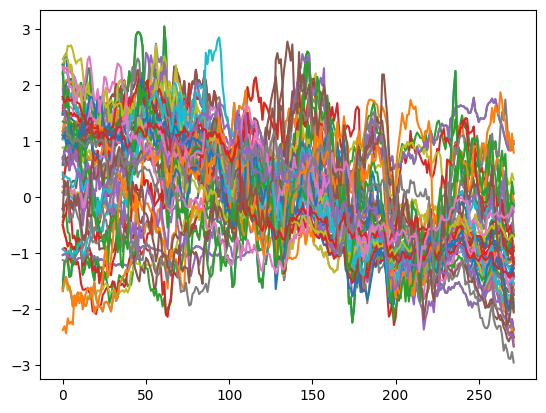

In [12]:
plt.plot(data_scaled.T)
plt.show()

In [13]:
data_scaled.size

21216

In [14]:
data_scaled_df = pd.DataFrame(data_scaled, index=df.index, columns=df.iloc[:,:-1].columns)

# DTW

Dynamic Time Warping (DTW) - это мера сходства между временными рядами

100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


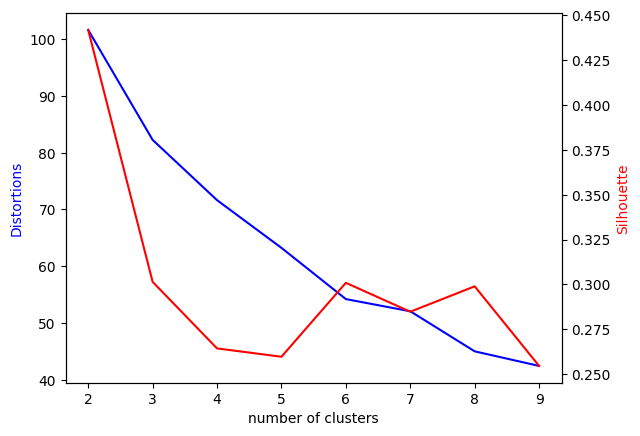

In [15]:
distortions = []
silhouette = []
K = range(2,10)
for k in tqdm(K):
  kmeanModel = TimeSeriesKMeans(n_clusters = k, metric = 'euclidean', n_jobs = 6, max_iter = 10, n_init = 5)
  kmeanModel.fit(data_scaled)
  distortions.append(kmeanModel.inertia_)
  silhouette.append(silhouette_score(data_scaled, kmeanModel.labels_, metric = 'euclidean'))

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('number of clusters')
ax1.set_ylabel('Distortions', color = 'b')
ax2.set_ylabel('Silhouette', color = 'r')

plt.show()

In [91]:
n_clusters = 3
ts_kmeans = TimeSeriesKMeans(n_clusters = n_clusters, metric = 'dtw', n_jobs = 6, max_iter = 10)
ts_kmeans.fit(data_scaled)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_jobs=6)

In [92]:
TimeSeriesKMeans(max_iter=10, n_clusters=3, n_jobs=6, metric = 'dtw')

TimeSeriesKMeans(max_iter=10, metric='dtw', n_jobs=6)

In [93]:
df['cluster_dtw'] = ts_kmeans.predict(data_scaled)

c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 78 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


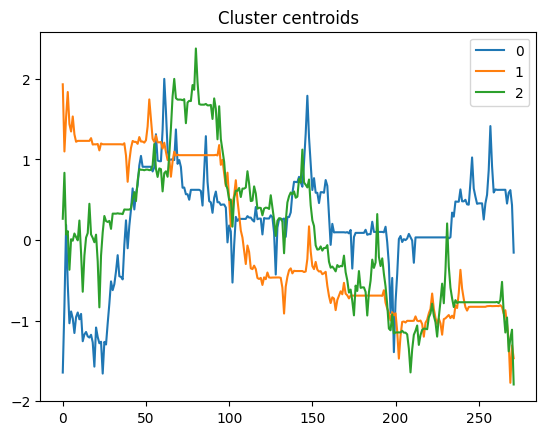

In [94]:
for cluster_number in range (n_clusters):
  plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label = cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [95]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(int(np.ceil(current_cluster.shape[0]/4)), \
                           4, figsize = (15, 3*int(np.ceil(current_cluster.shape[0]/4))))
    fig.autofmt_xdate(rotation = 45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[:-3])
        ax[index].set_title(f'{row.shortName}\n')
        plt.xticks(rotation = 45)

    plt.tight_layout()
    plt.show()

Cluster number0
------------------------------------------------------



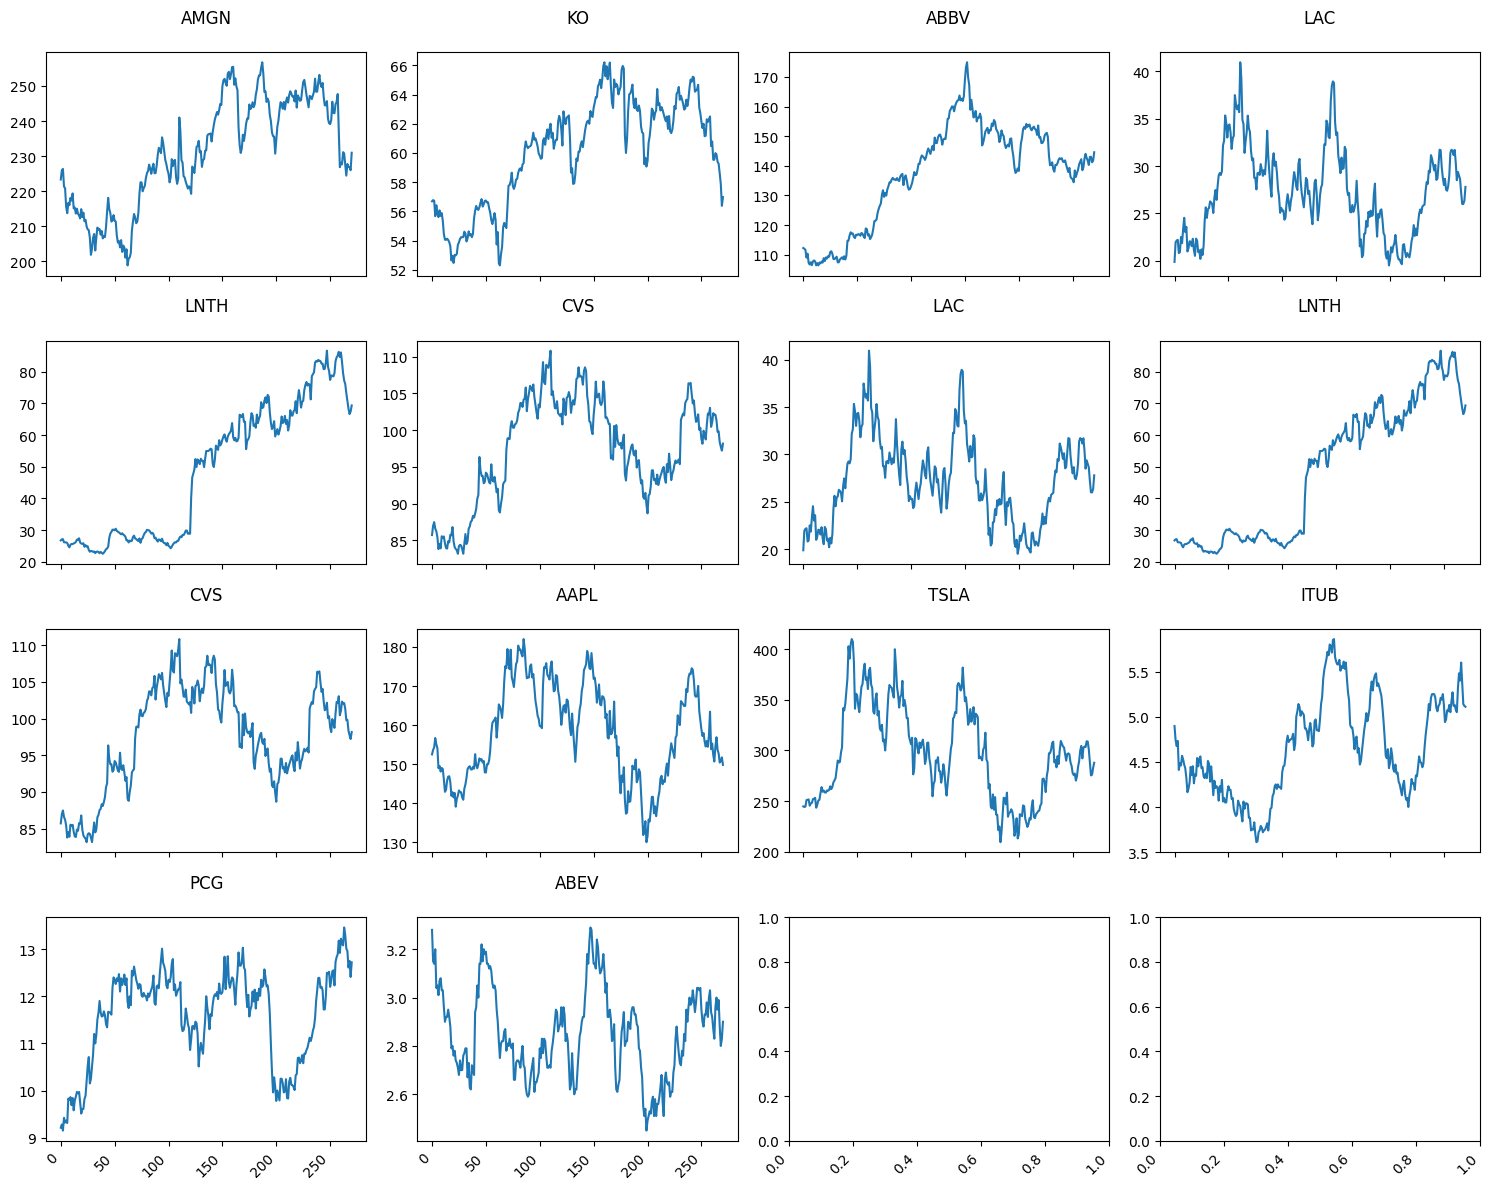

Cluster number1
------------------------------------------------------



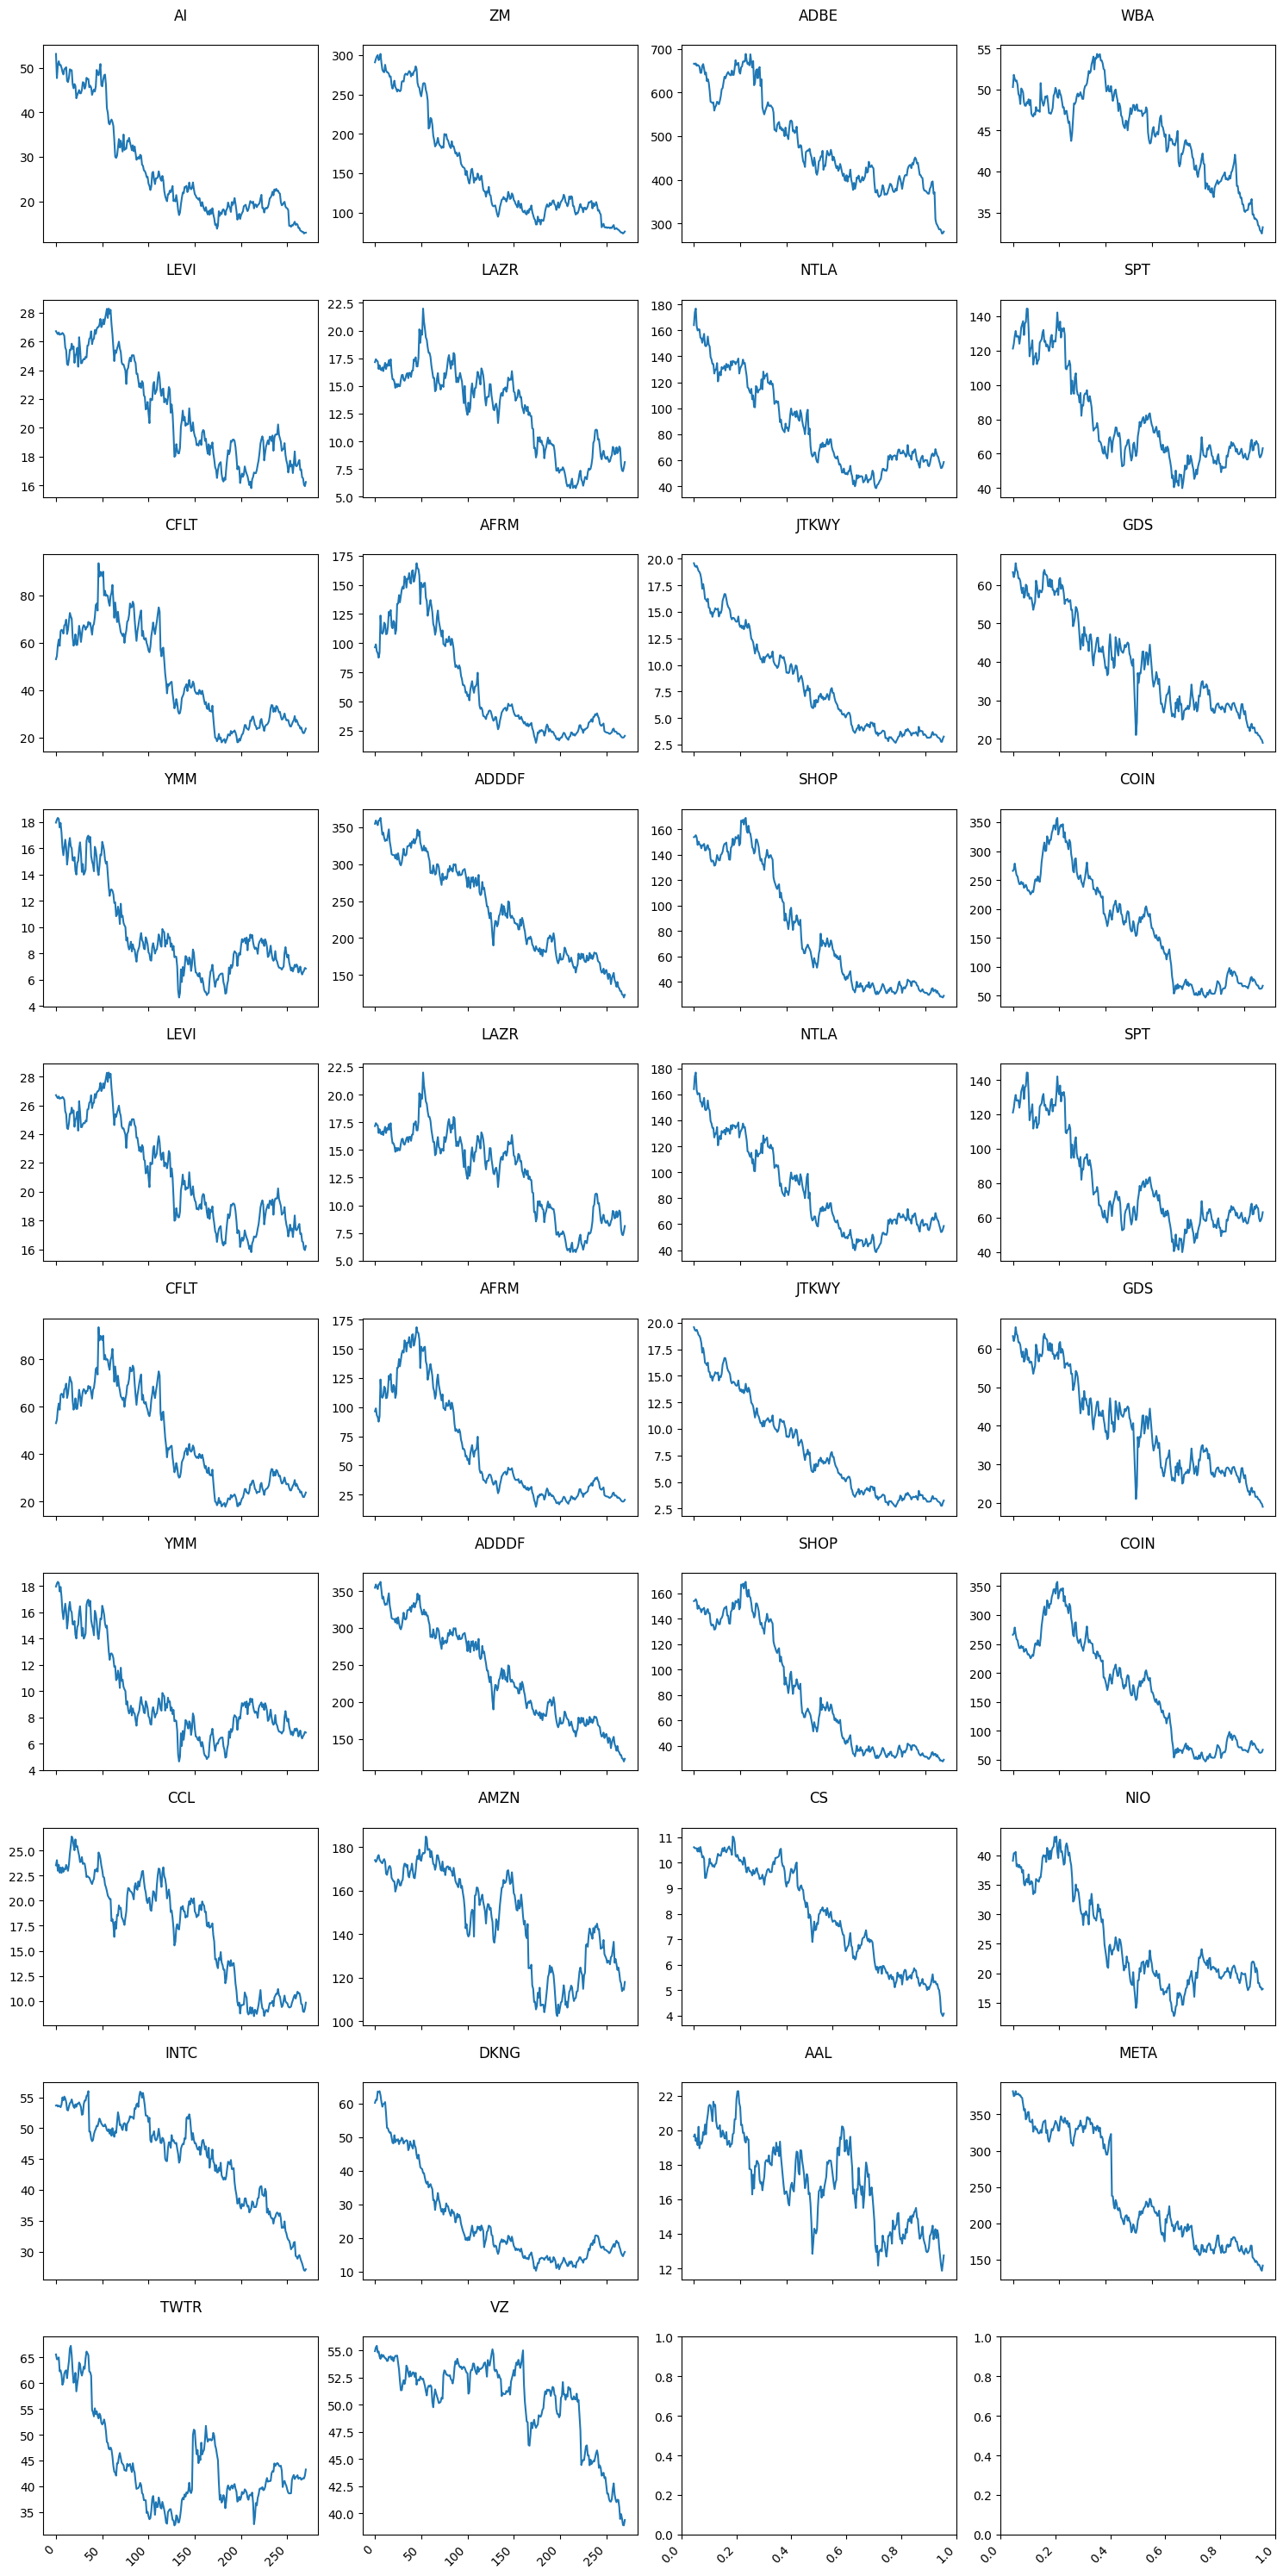

Cluster number2
------------------------------------------------------



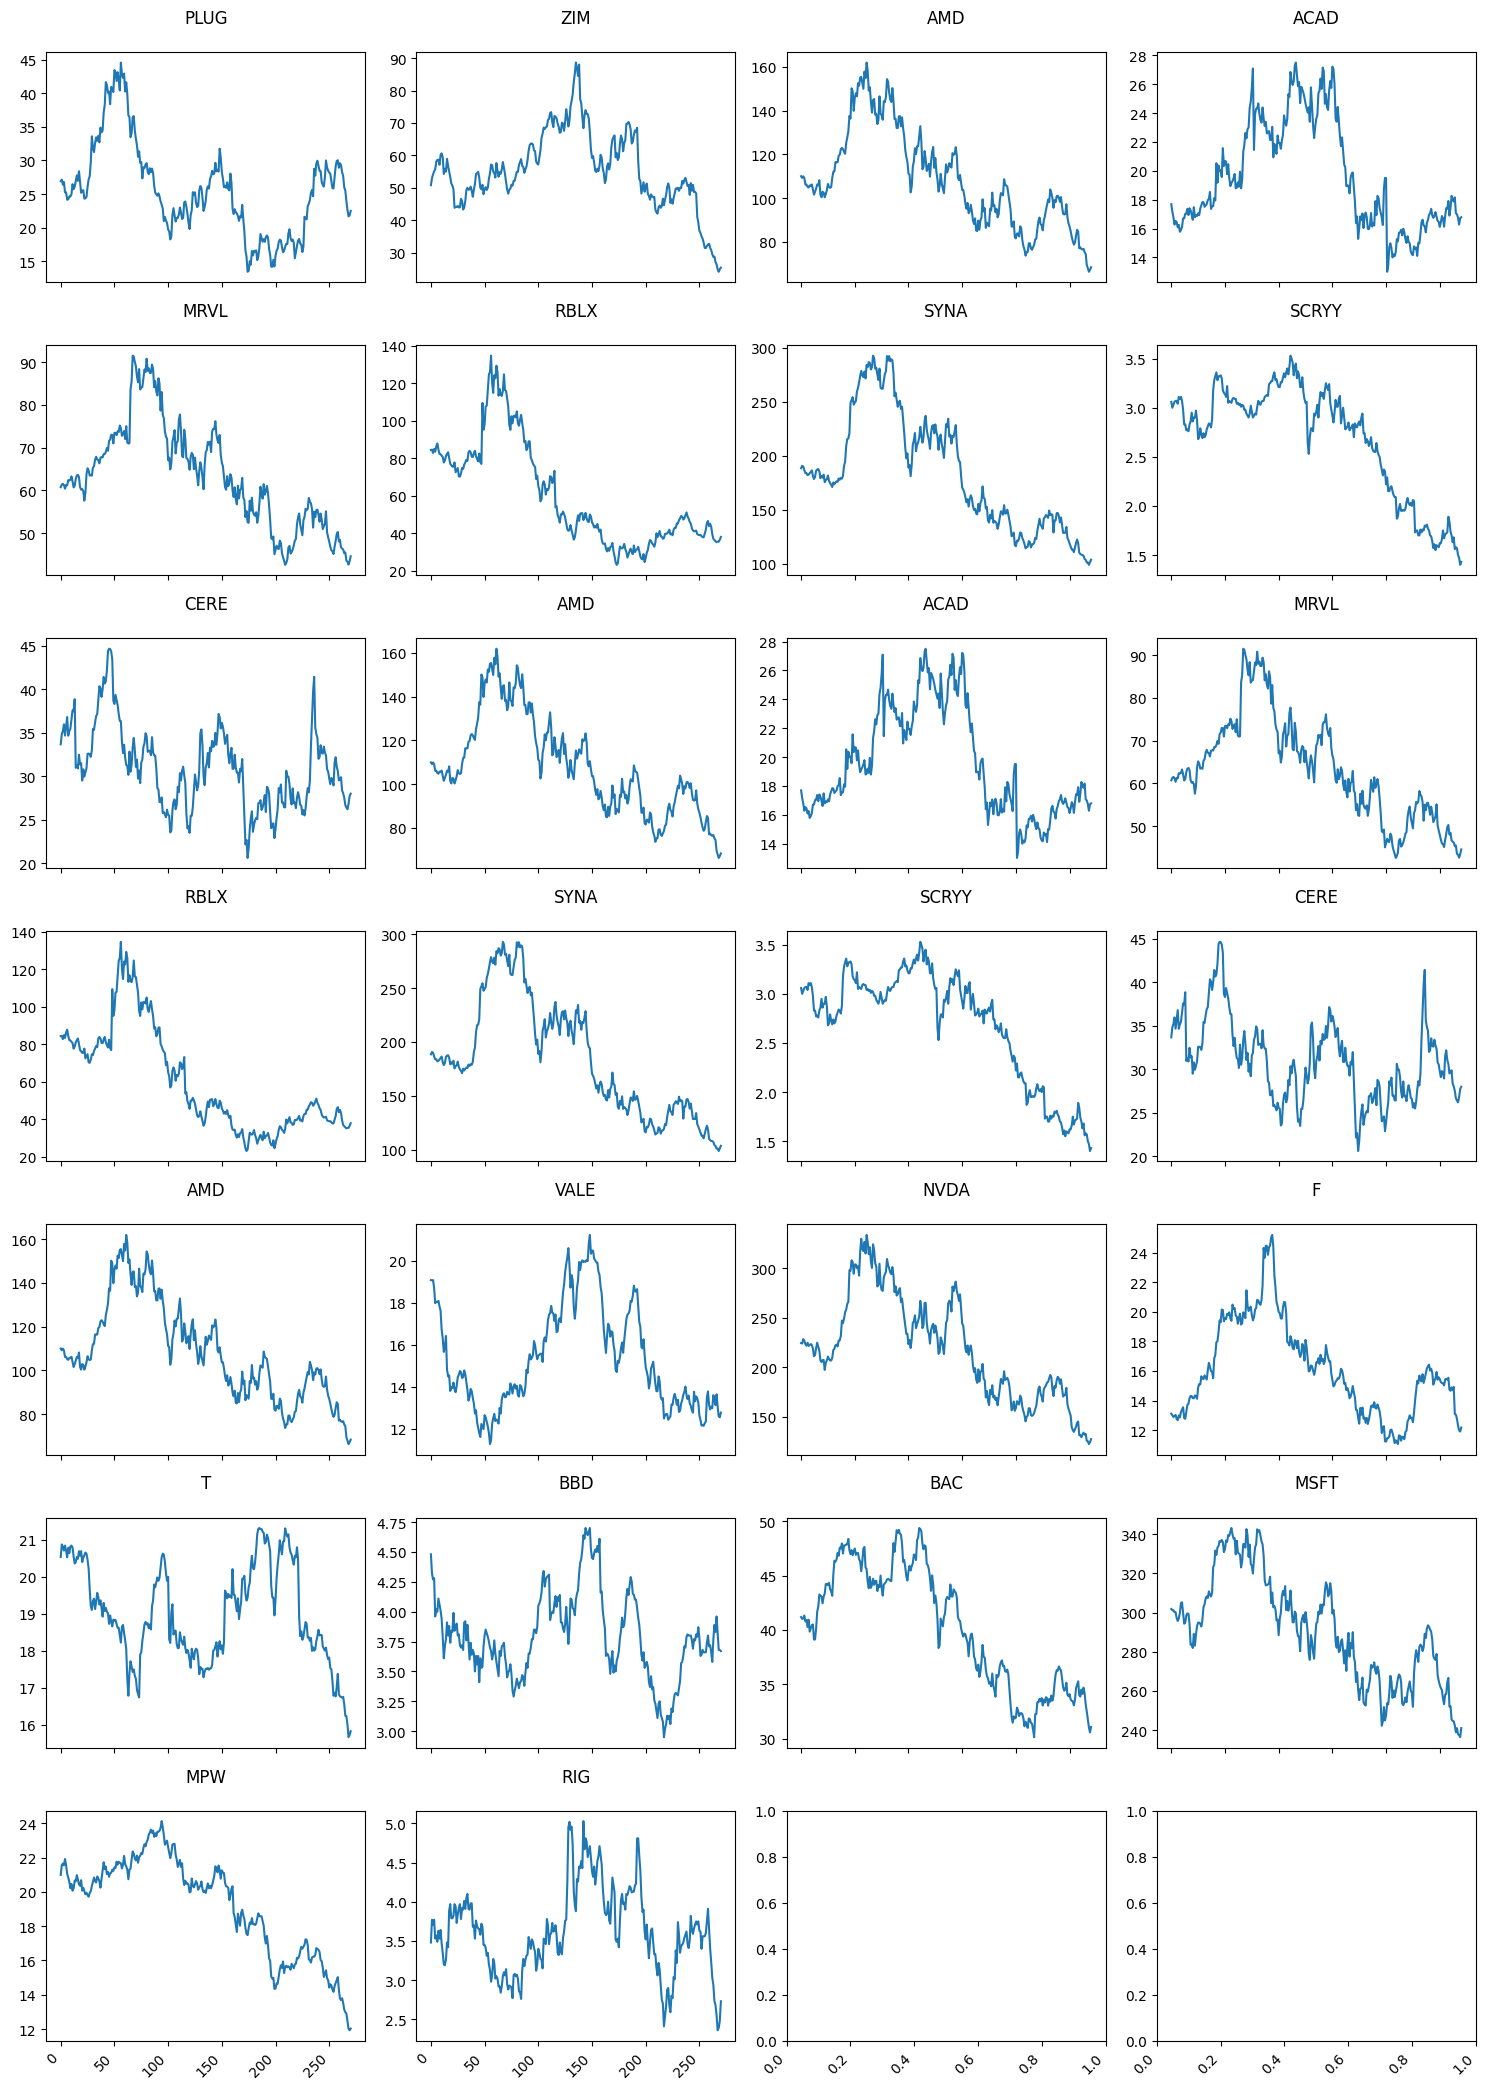

In [96]:
for cluster in range(n_clusters):
    print(f"Cluster number{cluster}")
    print("------------------------------------------------------\n")
    plot_cluster_tickers(df[df.cluster_dtw == cluster])

Попробуем применить другой подход

In [89]:
SEED=23

In [97]:
def get_kmeans_results(data, max_clusters=10, metric='euclidean', seed=23):
    # Главные метрики
    distortions = []
    silhouette = []
    clusters_range = range(1, max_clusters+1)
    
    for K in tqdm(clusters_range):
        kmeans_model = TimeSeriesKMeans(n_clusters=K, metric=metric, n_jobs=-1, max_iter=10, random_state=seed)
        kmeans_model.fit(data)
        distortions.append(kmeans_model.inertia_)
        if K > 1:
            silhouette.append(silhouette_score(data, kmeans_model.labels_))
        
    # Визуализация
    plt.figure(figsize=(10,4))
    plt.plot(clusters_range, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')
    
    plt.figure(figsize=(10,4))
    plt.plot(clusters_range[1:], silhouette, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette')

100%|██████████| 5/5 [00:47<00:00,  9.54s/it]

CPU times: total: 58.7 s
Wall time: 47.8 s


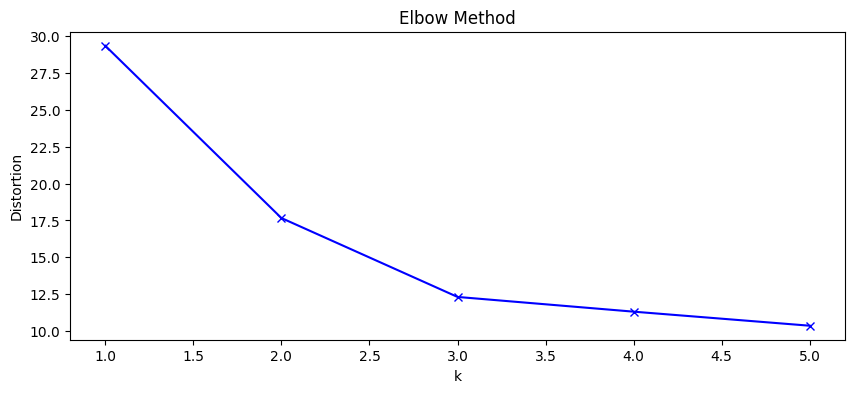

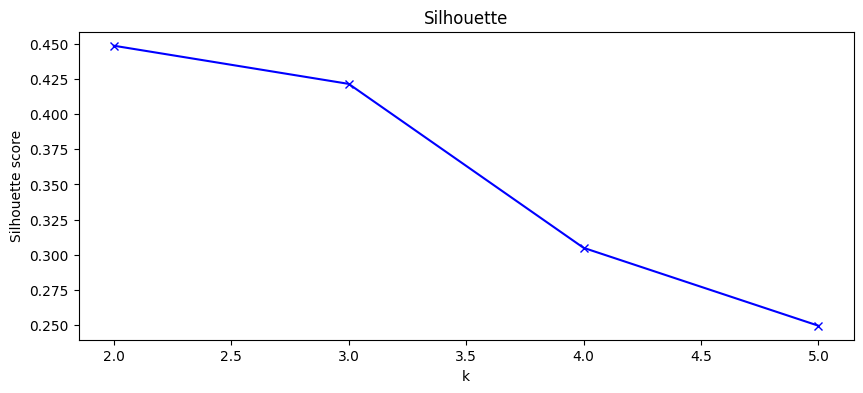

In [90]:
%%time

get_kmeans_results(data=data_scaled, max_clusters=5, metric='dtw', seed=SEED)

По графикам хорошо видно, что оптимальное число кластеров - 3. Попробуем посмотреть на них

In [98]:
# Визуализация для полученных кластеров 
def plot_clusters(data, cluster_model, dim_red_algo):
    cluster_labels = cluster_model.fit_predict(data)
    centroids = cluster_model.cluster_centers_
    u_labels = np.unique(cluster_labels)
    
    # Визуализация центроидов
    plt.figure(figsize=(16, 10))
    plt.scatter(centroids[:, 0] , centroids[:, 1] , s=150, color='r', marker="x")
    
    # Приведение данных к 2D формату
    if data.shape[1] > 2:
        data_2d = dim_red_algo.fit_transform(data)
        for u_label in u_labels:
            cluster_points = data[(cluster_labels == u_label)]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=u_label)
    else:
        for u_label in u_labels:
            cluster_points = data[(cluster_labels == u_label)]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=u_label)

    plt.title('Clustered Data')
    plt.xlabel("Feature space for the 1st feature")
    plt.ylabel("Feature space for the 2nd feature")
    plt.grid(True)
    plt.legend(title='Cluster Labels')

c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


CPU times: total: 14.6 s
Wall time: 7.66 s


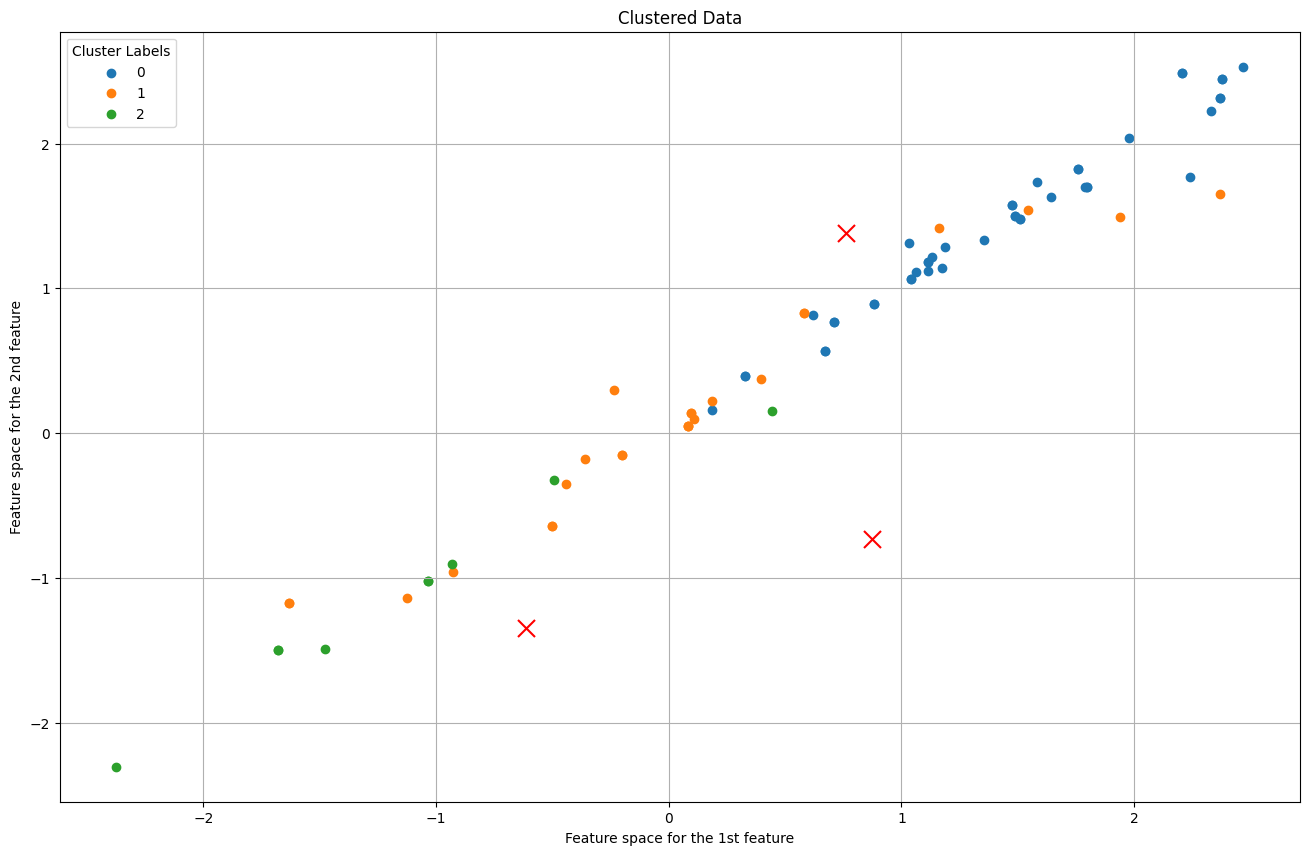

In [102]:
%%time

model = TimeSeriesKMeans(n_clusters=3, metric='dtw', n_jobs=-1, max_iter=10, random_state=SEED)

plot_clusters(data=data_scaled,
              cluster_model=model,
              dim_red_algo=TSNE(n_components=3, init='pca', random_state=SEED))

100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


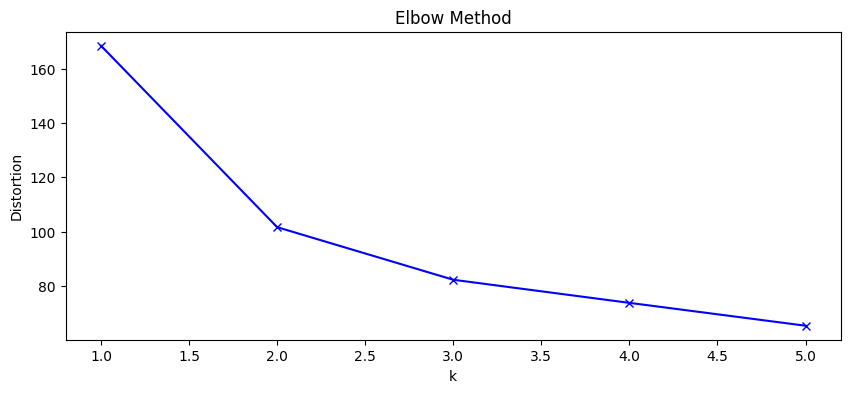

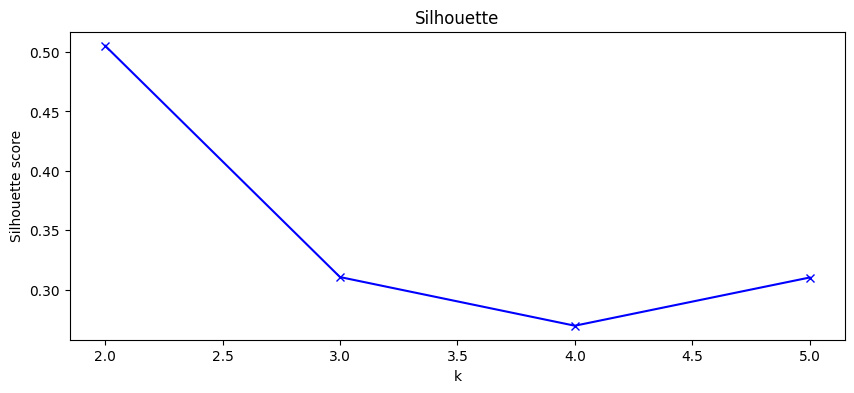

In [103]:
# давайте сравним с евклидовой метрикой
get_kmeans_results(data=data_scaled, max_clusters=5, metric='euclidean', seed=SEED)

Результаты намного хуже по сравнению с алгоритмом DTW

# DTW hierarchical clustering

In [50]:
data_btc = data_scaled_df.to_numpy()

In [51]:
timeseries = list(data_btc)

Матрица расстояний может быть использована для кластеризации временных рядов

In [52]:
# Custom Hierarchical clustering
model1 = clustering.Hierarchical(dtw.distance_matrix_fast, {})
cluster_idx = model1.fit(timeseries)
# Keep track of full tree by using the HierarchicalTree wrapper class
model2 = clustering.HierarchicalTree(model1)
cluster_idx = model2.fit(timeseries)
# You can also pass keyword arguments identical to instantiate a Hierarchical object
model2 = clustering.HierarchicalTree(dists_fun=dtw.distance_matrix_fast, dists_options={})
cluster_idx = model2.fit(timeseries)
# SciPy linkage clustering
model3 = clustering.LinkageTree(dtw.distance_matrix_fast, {})
cluster_idx = model3.fit(timeseries)

 99%|█████████▊| 77/78 [00:00<00:00, 11001.92it/s]


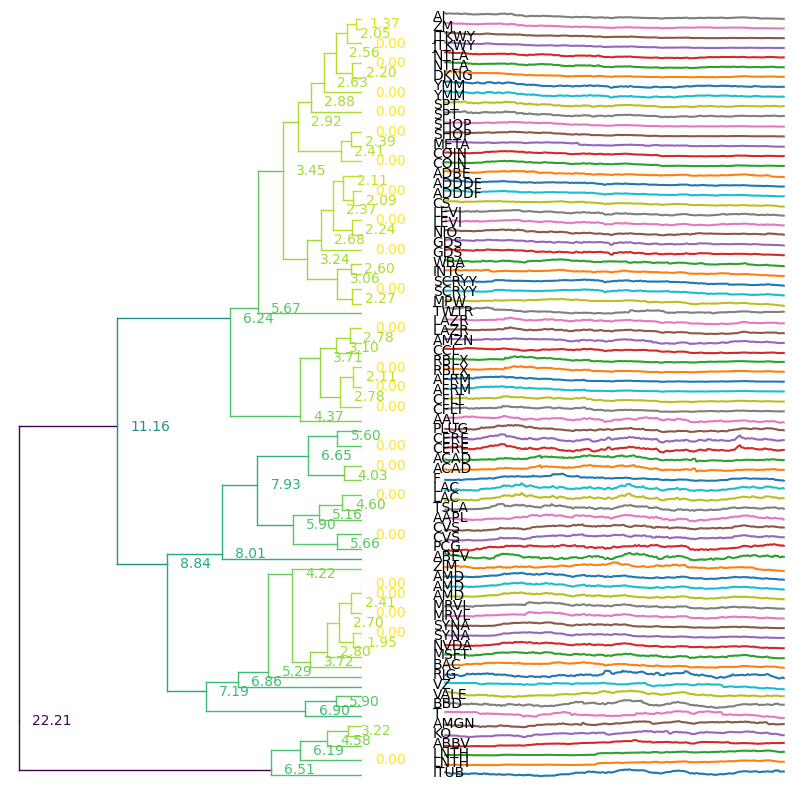

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
show_ts_label = lambda idx: data_scaled_df.index[idx]
model2.plot(axes=ax, show_ts_label=show_ts_label,
           show_tr_label=True, ts_label_margin=-10,
           ts_left_margin=10, ts_sample_length=1)
plt.show()

Базовая иерархическая кластеризация отличается от иерархической кластеризации DTW метрикой расстояния, используемой в алгоритме. В первом случае используется евклидова метрика, во втором -  расстояние DTW.

# DTW distance

DTW distance - меетрика расстояний между рядами (по сути, индексы временных рядов). Данный путь можно рассматривать как способ сопоставления участков временных рядов друг с другом безотносительно времени их появления.

Цель - найти такой путь, который будет минимизировать некоторую метрику расстояния между соответствующими участками временных рядов.

Порядок расчета:

- рассчитываем матрицу парных расстояний для каждой пары точек. Пара состоит из точки первого и точки второго ряда
- рассчитывается матрицу потерь, которая корректирует расстояние между парой точек исходя из соседних значений матрицы расстояния
- находится путь обхода матрицы потерь так, чтобы они были минимальны

-----

# Другой вариант кластеризации:

In [104]:
from scipy.cluster.hierarchy import linkage

In [112]:
np_df = data_scaled_df.iloc[:, 1:].to_numpy(dtype=np.double) 

DTW необходимо ускорить, чтобы его можно было использовать. Один из способов сделать это - ограничить задержку между сериями, чтобы избежать сравнения с точками данных, которые находятся слишком далеко друг от друга. Это может быть достигнуто с помощью "окон" w.

In [107]:
def DTWDistance(s1, s2,w=10):
    DTW={}
    w = max(w, abs(len(s1)-len(s2)))
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist = (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])


При расчете DTW со сложностью $$О(n^2)$$, более хорошим подходом является рассмотрение аппроксимации. Нижняя граница имеет сложность $$О(n)$$

Допустим, вы хотите найти ближайший временной ряд к одному экземпляру. Вы можете перебрать всех кандидатов и проверить нижнюю границу. Если нижняя граница для нового кандидата не ниже наименьшего расстояния для вашего текущего наилучшего результата, вы можете пропустить весь расчет DTW.

In [155]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    return np.sqrt(LB_sum)

Пробуем провести кластеризацию

In [156]:
import random

def k_means_clust(data,num_clust,num_iter,w=5):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        print(counter)
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
    
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+np.array(data[k])
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    
    return centroids, assignments

In [116]:
%%time

centroids, assignments = k_means_clust(np_df.tolist(),num_clust=10,num_iter=5,w=5)

1
2
3
4
5
CPU times: total: 51.4 s
Wall time: 52 s


Посмотрим на центроинды

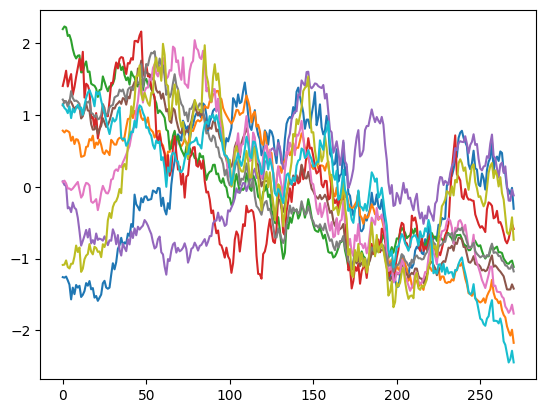

In [117]:
plt.plot(np.array(centroids).transpose())